In [5]:
!pip install -q timm transformers

Step 1: Setting up models...
Using device: cuda


You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


✓ Models loaded successfully!

Step 2: Loading images...
✓ Images loaded
  Before: (720, 720)
  After: (720, 720)
  ✓ Images are different - proceeding with comparison

Step 3: Extracting semantic features...
  Using 256 spatial tokens (16x16)
  Using 256 spatial tokens (16x16)
✓ Extracted patch features: 16x16 grid
  Each patch has 1024 features

Step 4: Computing semantic differences...
✓ Semantic difference computed
  Average change: 0.107

Step 5: Segmenting changed regions...
  Using 8 sample points for segmentation
  Generated 3 unique masks
✓ Generated 3 candidate masks

Step 6: Analyzing detected regions...
✓ Analyzed 3 regions

Step 7: Visualizing results...


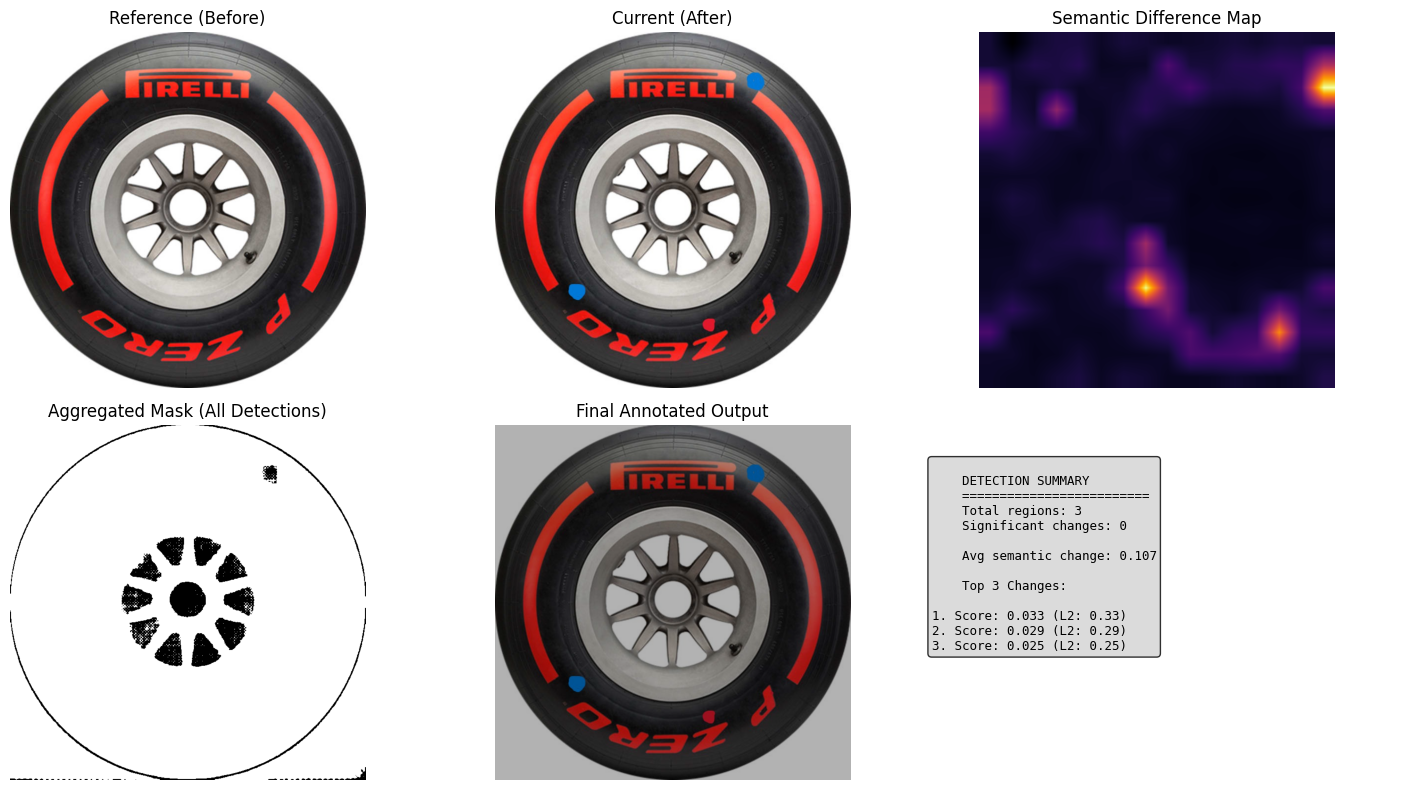

✓ Visualization complete!

Step 8: Exporting results...
✓ Results exported to results.json

PROCESS COMPLETE!
Detected 3 total regions
Found 0 significant changes

Files saved:
  - comparison_results.png
  - results.json


In [8]:
# ========================================================================
# SIMPLE VISUAL DIFFERENCE ENGINE - 2 Image Comparison
# ========================================================================
# A clean, easy-to-use implementation for detecting changes between images
# Uses: DINOv3 (semantic features) + SAM2 (segmentation)
# ========================================================================

!pip install -q timm transformers torch opencv-python-headless matplotlib requests

import torch
import timm
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import Sam2Processor, Sam2Model
import requests
import json
import warnings

# ========================================================================
# STEP 1: SETUP & CONFIGURATION
# ========================================================================

print("Step 1: Setting up models...")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load DINOv3 for feature extraction
dino_model = timm.create_model(
    'vit_large_patch16_dinov3.lvd1689m',
    pretrained=True,
    num_classes=0  # Remove classifier, get embeddings only
).to(device)
dino_model.eval()

# Get DINOv3 transforms
data_config = timm.data.resolve_model_data_config(dino_model)
dino_transform = timm.data.create_transform(**data_config, is_training=False)

# Load SAM2 for segmentation (suppress warning)
warnings.filterwarnings('ignore', message='.sam2_video.')

sam_model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)
sam_processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")

print("✓ Models loaded successfully!\n")

# ========================================================================
# STEP 2: LOAD TWO IMAGES
# ========================================================================

print("Step 2: Loading images...")

def load_image_from_url(url):
    """Load image from URL"""
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")

def load_image_from_path(path):
    """Load image from local path"""
    return Image.open(path).convert("RGB")

# ========================================================================
# 🔧 CONFIGURE YOUR IMAGES HERE
# ========================================================================

# METHOD 1: Use local file paths (RECOMMENDED)
USE_LOCAL_FILES = True  # Set to True to use local files

if USE_LOCAL_FILES:
    # ⚠️ Using the file paths you provided
    try:
        img_before = load_image_from_path('/content/race_car_tire_1.jpeg')
        img_after = load_image_from_path('/content/race_car_tire_1_anomaly.jpeg')
    except FileNotFoundError:
        print("⚠️ YOUR IMAGE PATHS WERE NOT FOUND. Using test URLs.")
        print("Please upload your images or change the file paths.")
        USE_LOCAL_FILES = False

if not USE_LOCAL_FILES:
    # METHOD 2: Use URLs (for testing)
    img_before_url = "https://huggingface.co/datasets/hf-internal-testing/sam2-fixtures/resolve/main/truck.jpg"
    img_after_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/dog-sam.png"

    print(f"Loading from URL: {img_before_url}")
    img_before = load_image_from_url(img_before_url)
    print(f"Loading from URL: {img_after_url}")
    img_after = load_image_from_url(img_after_url)

# ========================================================================

print(f"✓ Images loaded")
print(f"  Before: {img_before.size}")
print(f"  After: {img_after.size}")

# Resize if images are different sizes
if img_before.size != img_after.size:
    print(f"  ⚠  Resizing 'after' image to match 'before': {img_before.size}")
    img_after = img_after.resize(img_before.size, Image.LANCZOS)

# Check if images are identical
if img_before.tobytes() == img_after.tobytes():
    print("\n⚠  WARNING: Images are identical! No differences will be detected.")
    print("  Please provide different 'before' and 'after' images.\n")
else:
    print("  ✓ Images are different - proceeding with comparison\n")

# ========================================================================
# STEP 3: EXTRACT FEATURES WITH DINOv3
# ========================================================================

print("Step 3: Extracting semantic features...")

def extract_patch_features(model, transform, img):
    """
    Extract patch-level features from image
    Returns: (patch_grid, grid_shape)
    """
    # Transform image
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        features = model.forward_features(img_tensor)

    # DINOv3 includes registers (extra tokens) beyond CLS
    # Format: [CLS, patch_tokens..., register_tokens]
    # We need to extract only the spatial patch tokens

    batch_size = features.shape[0]
    num_tokens = features.shape[1]
    embed_dim = features.shape[2]

    # Heuristic: Take tokens after CLS, assume square grid of largest size
    tokens_after_cls = features[:, 1:, :]
    num_spatial = tokens_after_cls.shape[1]

    # Find largest square grid that fits
    grid_size = int(np.sqrt(num_spatial))
    while grid_size * grid_size > num_spatial:
        grid_size -= 1

    # Take only the spatial tokens (discard registers)
    num_spatial_tokens = grid_size * grid_size
    patch_features = tokens_after_cls[:, :num_spatial_tokens, :]

    print(f"  Using {num_spatial_tokens} spatial tokens ({grid_size}x{grid_size})")

    # Reshape to grid
    patch_grid = patch_features.reshape(batch_size, grid_size, grid_size, embed_dim)
    patch_grid = patch_grid.squeeze(0).cpu().numpy()

    return patch_grid, (grid_size, grid_size)

# Extract features for both images
patches_before, grid_shape = extract_patch_features(dino_model, dino_transform, img_before)
patches_after, _ = extract_patch_features(dino_model, dino_transform, img_after)

print(f"✓ Extracted patch features: {grid_shape[0]}x{grid_shape[1]} grid")
print(f"  Each patch has {patches_before.shape[2]} features")
print()

# ========================================================================
# STEP 4: COMPUTE SEMANTIC DIFFERENCE MAP
# ========================================================================

print("Step 4: Computing semantic differences...")

def compute_semantic_diff(patches1, patches2):
    """
    Compute L2 distance between patch embeddings
    Returns: Normalized difference map
    """
    # Compute L2 distance for each patch
    diff_map = np.linalg.norm(patches2 - patches1, axis=-1)

    # Normalize to [0, 1]
    diff_map = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)

    return diff_map

# Compute difference
semantic_diff = compute_semantic_diff(patches_before, patches_after)

# Upsample to image size for visualization
semantic_heatmap = cv2.resize(
    semantic_diff,
    img_after.size,
    interpolation=cv2.INTER_LINEAR
)

print(f"✓ Semantic difference computed")
print(f"  Average change: {semantic_diff.mean():.3f}")

# Warning for completely different images
if semantic_diff.mean() > 0.6:
    print("\n  ⚠  WARNING: Very high average change detected!")
    print("    This suggests the images are completely different scenes.")
    print("    For best results, use images of the SAME scene at different times.\n")

print()

# ========================================================================
# STEP 5: SEGMENT CHANGED REGIONS WITH SAM2
# ========================================================================

print("Step 5: Segmenting changed regions...")

def generate_sam_masks(image, heatmap, processor, model, threshold=0.25, num_points=32):
    """
    Generate segmentation masks using SAM2
    Uses heatmap to place points in high-change areas
    """
    high_change_mask = heatmap > threshold
    ys_high, xs_high = np.where(high_change_mask)

    all_ys = ys_high
    all_xs = xs_high

    if len(all_xs) == 0:
        print(f"  No significant changes detected (threshold={threshold})")
        return []

    # Sample points strategically
    points = []
    if len(all_xs) > num_points:
        # Grid-based sampling for better coverage
        h, w = heatmap.shape
        grid_h, grid_w = 4, 4 # 4x4 grid
        cell_h, cell_w = h // grid_h, w // grid_w

        for i in range(grid_h):
            for j in range(grid_w):
                in_cell = (
                    (all_ys >= i * cell_h) & (all_ys < (i + 1) * cell_h) &
                    (all_xs >= j * cell_w) & (all_xs < (j + 1) * cell_w)
                )
                cell_indices = np.where(in_cell)[0]

                if len(cell_indices) > 0:
                    # Take the point with highest heatmap value in this cell
                    cell_ys = all_ys[cell_indices]
                    cell_xs = all_xs[cell_indices]
                    cell_values = heatmap[cell_ys, cell_xs]
                    best_local = cell_indices[cell_values.argmax()]
                    points.append([int(all_xs[best_local]), int(all_ys[best_local])])
    else:
        # Take all points if they are fewer than num_points
        points = [[int(all_xs[i]), int(all_ys[i])] for i in range(len(all_xs))]

    if len(points) == 0:
        return []

    print(f"  Using {len(points)} sample points for segmentation")

    # Group points into batches
    all_masks = []
    batch_size = 8 # Process 8 points at a time
    for i in range(0, len(points), batch_size):
        batch_points = points[i:i+batch_size]

        # Each point becomes a separate object prompt
        input_points = [[[pt] for pt in batch_points]]
        input_labels = [[[1] for _ in batch_points]] # 1 = foreground point

        inputs = processor(
            images=image,
            input_points=input_points,
            input_labels=input_labels,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs, multimask_output=False) # Get one best mask per point

        masks = processor.post_process_masks(
            outputs.pred_masks.cpu(),
            inputs["original_sizes"]
        )[0]

        for j, mask_tensor in enumerate(masks):
            mask_np = mask_tensor.squeeze().numpy() # (H, W)

            # Filter tiny or huge masks
            mask_area = mask_np.sum()
            img_area = mask_np.shape[0] * mask_np.shape[1]

            if 1000 < mask_area < img_area * 0.8:
                all_masks.append(mask_np)

    # Remove duplicate masks using IoU
    unique_masks = []
    for mask in all_masks:
        is_duplicate = False
        for existing in unique_masks:
            intersection = np.logical_and(mask, existing).sum()
            union = np.logical_or(mask, existing).sum()
            iou = intersection / (union + 1e-8)
            if iou > 0.7:  # 70% overlap = duplicate
                is_duplicate = True
                break
        if not is_duplicate:
            unique_masks.append(mask)

    print(f"  Generated {len(unique_masks)} unique masks")
    return unique_masks

# Generate masks
masks = generate_sam_masks(
    img_after,
    semantic_heatmap,
    sam_processor,
    sam_model,
    threshold=0.25,
    num_points=32
)

print(f"✓ Generated {len(masks)} candidate masks")
print()

# ========================================================================
# STEP 6: ANALYZE EACH REGION
# ========================================================================

print("Step 6: Analyzing detected regions...")

def get_bbox_from_mask(mask):
    """Extract bounding box from mask"""
    if mask.ndim == 3: mask = mask[0] # Handle any lingering dims
    ys, xs = np.where(mask > 0)
    if len(xs) == 0: return None
    return [int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())]

def analyze_region(mask, patches_before, patches_after, grid_shape):
    """Analyze a region by computing its semantic change score"""
    if mask.ndim == 3: mask = mask[0]

    # Resize mask to patch grid size
    mask_resized = cv2.resize(
        mask.astype(np.uint8),
        (grid_shape[1], grid_shape[0]), # (width, height) for cv2.resize
        interpolation=cv2.INTER_NEAREST
    )

    if mask_resized.sum() == 0: return None

    # Get average embedding for this region
    region_mask = mask_resized > 0
    emb_before = patches_before[region_mask].mean(axis=0)
    emb_after = patches_after[region_mask].mean(axis=0)

    # Compute change metrics
    l2_distance = np.linalg.norm(emb_after - emb_before)
    cosine_sim = np.dot(emb_before, emb_after) / (
        np.linalg.norm(emb_before) * np.linalg.norm(emb_after) + 1e-8
    )
    cosine_distance = 1 - cosine_sim

    return {
        'l2': l2_distance,
        'cosine': cosine_distance,
        'area': mask.sum()
    }

# Analyze all regions
regions = []
for mask in masks:
    bbox = get_bbox_from_mask(mask)
    if bbox is None: continue

    metrics = analyze_region(mask, patches_before, patches_after, grid_shape)
    if metrics is None: continue

    regions.append({
        'bbox': bbox,
        'mask': mask,
        'metrics': metrics
    })

# Sort by change magnitude (L2 distance)
regions = sorted(regions, key=lambda r: r['metrics']['l2'], reverse=True)

# Normalize scores and flag changes
if len(regions) > 0:
    l2_scores = [r['metrics']['l2'] for r in regions]
    l2_min, l2_max = min(l2_scores), max(l2_scores)

    if (l2_max - l2_min) < 0.1: # If all scores are very similar
        for r in regions:
            r['score'] = min(1.0, r['metrics']['l2'] / 10.0) # Scale L2 to 0-1
            r['changed'] = r['metrics']['l2'] > 2.0 # Absolute L2 threshold
    else:
        # Normal normalization
        for r in regions:
            r['score'] = (r['metrics']['l2'] - l2_min) / (l2_max - l2_min + 1e-8)
            r['changed'] = r['score'] > 0.25 # Relative threshold

print(f"✓ Analyzed {len(regions)} regions")
print()

# ========================================================================
# STEP 7: VISUALIZE RESULTS (MODIFIED TO MATCH PREVIOUS STYLE)
# ========================================================================

print("Step 7: Visualizing results...")

def show_simple_results(img_before, img_after, semantic_heatmap, regions):
    """Create the 5-plot (2x3) visualization requested"""

    # --- 1. Create the Aggregated Mask (for plot 4) ---
    h, w = img_after.size[1], img_after.size[0]
    aggregated_mask_np = np.zeros((h, w), dtype=np.uint8)

    for region in regions:
        mask = region['mask']
        if mask.ndim == 3: mask = mask[0]

        mask_binary = (mask > 0).astype(np.uint8) * 255

        if mask_binary.shape != (h, w):
            mask_binary = cv2.resize(mask_binary, (w, h), interpolation=cv2.INTER_NEAREST)

        aggregated_mask_np = np.maximum(aggregated_mask_np, mask_binary)

    # --- 2. Create the Final Annotated Output (for plot 5) ---
    annotated_img = np.array(img_after.copy())
    overlay = np.zeros_like(annotated_img, dtype=np.float32)

    # Get only significant changes
    changed_regions = [r for r in regions if r['changed']]

    for region in changed_regions:
        mask = region['mask']
        bbox = region['bbox']
        x1, y1, x2, y2 = bbox

        if mask.ndim == 3: mask = mask[0]

        mask_float = (mask > 0).astype(np.float32)
        if mask_float.shape != (h, w):
             mask_float = cv2.resize(mask_float, (w, h), interpolation=cv2.INTER_LINEAR)

        # Apply random color overlay
        color = np.random.rand(3)
        for i in range(3):
            overlay[:, :, i] += mask_float * color[i]

        # Draw bounding box
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add label
        label = f"Score: {region['score']:.2f}"
        cv2.putText(annotated_img, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Blend overlay
    overlay = np.clip(overlay, 0, 1)
    annotated_float = annotated_img.astype(np.float32) / 255.0
    annotated_blended = cv2.addWeighted(annotated_float, 0.7, overlay, 0.6, 0)
    annotated_final = (annotated_blended * 255).astype(np.uint8)

    # --- 3. Create the Plot ---
    plt.figure(figsize=(15, 8)) # Use the 2x3 layout

    # Plot 1: Before
    plt.subplot(2, 3, 1)
    plt.title("Reference (Before)")
    plt.imshow(img_before)
    plt.axis('off')

    # Plot 2: After
    plt.subplot(2, 3, 2)
    plt.title("Current (After)")
    plt.imshow(img_after)
    plt.axis('off')

    # Plot 3: Difference Map
    plt.subplot(2, 3, 3)
    plt.title("Semantic Difference Map")
    plt.imshow(semantic_heatmap, cmap='inferno')
    plt.axis('off')

    # Plot 4: Aggregated Mask
    plt.subplot(2, 3, 4)
    plt.title("Aggregated Mask (All Detections)")
    plt.imshow(aggregated_mask_np, cmap='gray')
    plt.axis('off')

    # Plot 5: Final Output
    plt.subplot(2, 3, 5)
    plt.title("Final Annotated Output")
    plt.imshow(annotated_final)
    plt.axis('off')

    # Plot 6: Summary Statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    summary_text = f"""
    DETECTION SUMMARY
    {'='*25}
    Total regions: {len(regions)}
    Significant changes: {len(changed_regions)}

    Avg semantic change: {semantic_heatmap.mean():.3f}

    Top 3 Changes:
    """
    for i, region in enumerate(regions[:3], 1):
         summary_text += f"\n{i}. Score: {region['score']:.3f} (L2: {region['metrics']['l2']:.2f})"

    ax6.text(0.05, 0.9, summary_text,
             transform=ax6.transAxes,
             fontsize=9,
             verticalalignment='top',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))


    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
    plt.show()

# Generate visualization
show_simple_results(img_before, img_after, semantic_heatmap, regions)

print("✓ Visualization complete!")
print()

# ========================================================================
# STEP 8: EXPORT RESULTS
# ========================================================================

print("Step 8: Exporting results...")

def export_results(regions, filename='results.json'):
    """Export results to JSON"""
    output = {
        'total_regions': len(regions),
        'significant_changes': sum(1 for r in regions if r['changed']),
        'regions': []
    }

    for i, region in enumerate(regions):
        output['regions'].append({
            'id': i,
            'bbox': region['bbox'],
            'score': float(region['score']),
            'changed': bool(region['changed']),  # Convert numpy bool to Python bool
            'metrics': {
                'l2_distance': float(region['metrics']['l2']),
                'cosine_distance': float(region['metrics']['cosine']),
                'area_pixels': int(region['metrics']['area'])
            }
        })

    with open(filename, 'w') as f:
        json.dump(output, f, indent=2)

    print(f"✓ Results exported to {filename}")

export_results(regions)

# ========================================================================
# SUMMARY
# ========================================================================

print("\n" + "="*60)
print("PROCESS COMPLETE!")
print("="*60)
print(f"Detected {len(regions)} total regions")
print(f"Found {sum(1 for r in regions if r['changed'])} significant changes")
print("\nFiles saved:")
print("  - comparison_results.png")
print("  - results.json")
print("="*60)